# MORDM Optimization 

In [1]:
# initialize all the functions and libraries for running this notebook
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench import Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter, BooleanParameter, Policy
from SALib.analyze import sobol

from ema_workbench.analysis import prim
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import pairs_plotting
from ema_workbench.em_framework.optimization import GenerationalBorg

from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

from dike_model_function import DikeNetwork

from ProblemFormulationSelf import problem_definition
from helper import agg

from ema_workbench import save_results
from ema_workbench.util.utilities import load_results

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


<Logger EMA (DEBUG)>

### 1. Pre- optimizaton: Testing for the right epsilon values 
#### experiments on dikering 4 and 5
First, we need to check what epsilon value is the best to use. We do this with smaller runs (nfe = 10,000) on the variables concerning A4 and A5.

The reference scenario is set at the average level, 'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5, 'discount rate': 3.5 and 'ID flood wave shape': 4, because we believe this will give us the favourable policies under normal case. 

Given the considerations on multi-actor context, after doing these small experiments to find the best epsilon values, larger experiments with nfe = 100,000 would be done to minimize the total deaths, costs and damages for all locations. This would give us solutions that have a better chance to get accepted in the political decision making arena.The reasoning behind this is quite logical, our optimal solution with minimizing cost, deaths and damages is having Gelderland implement Room for the River projects in each location, this would leave us with significantly lower dike increments, if any.

In [20]:
model, planning_steps = problem_definition('A4, A5 vars')

It should be noted that we changed the provided problem_formulation python file, such that we don't need to specify the directions of the outcomes (i.e., minimize or maximize) here. 

#### epssilon = 0.5

In [21]:
reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate': 3.5,
                        'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name[:-2]]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]
epsilon = [0.05,] * len(model.outcomes)
nfe=10000

In [5]:
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 993/10000 nfe
[MainProcess/INFO] generation 15: 1493/10000 nfe
[MainProcess/INFO] generation 20: 1993/10000 nfe
[MainProcess/INFO] generation 25: 2491/10000 nfe
[MainProcess/INFO] generation 30: 2988/10000 nfe
[MainProcess/INFO] generation 35: 3488/10000 nfe
[MainProcess/INFO] generation 40: 3986/10000 nfe
[MainProcess/INFO] generation 45: 4485/10000 nfe
[MainProcess/INFO] generation 50: 4984/10000 nfe
[MainProcess/INFO] generation 55: 5481/10000 nfe
[MainProcess/INFO] generation 60: 5980/10000 nfe
[MainProcess/INFO] generation 65: 6478/10000 nfe
[MainProcess/INFO] generation 70: 6977/10000 nfe
[MainProcess/INFO] generation 75: 7473/10000 nfe
[MainProcess/INFO] generation 80: 7970/10000 nfe
[MainProcess/INFO] generation 85: 8467/10000 nfe
[MainProcess/INFO] generation 90: 8963/10000 nfe
[MainProcess/INFO] generation 95: 9462/10000

In [10]:
total = results, convergence
save_results(total, './data/exp/a4-5_10000nfemoea')

[MainProcess/INFO] results saved successfully to c:\TEMP\Programming\EPA1361\final assignment\data\exp\a4-5_10000nfemoea


In [14]:
results, convergence = load_results('./data/exp/a4-5_10000nfemoea')

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\a4-5_10000nfemoea


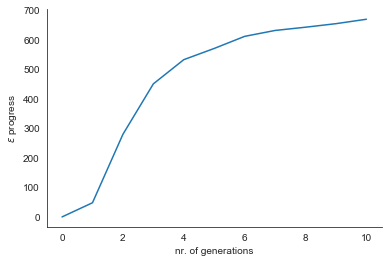

In [25]:
## Check convergency
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence['epsilon_progress'])
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

The figure above shows us the epsilon progress during the experimentations. The figure seems to be stailizing, but this cannot be said for sure as we have to little experiments (generations) to actually check this. 

In [28]:
len(results)

34

When epsilion equals 0.5, 34 optimal solutions could be found

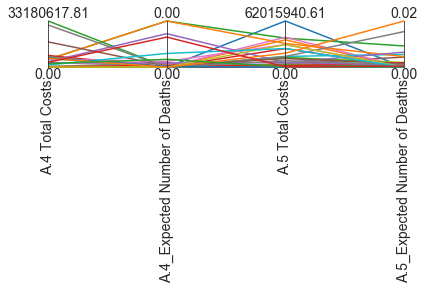

In [17]:
# visualize the tradeoffs

outcomes = results.loc[:, [ 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.savefig ('epsilon_experiments_A4A5')
plt.show()

We see that the deaths are always really close to 0 and the cost are for dike ring 4 and 5 are combined around 100 million (including damages and heightening investments), which is relatively low.

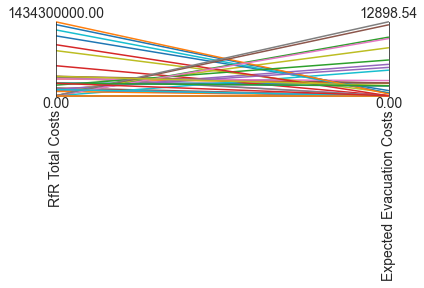

In [9]:
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs',]]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
 
plt.show()

Looking at the evaluation costs and RfR total costs we see that RfR sometimes can get quite extensive for the two dikes combined. Besides, there is a clear trade-off between cheap RfR and the high evacuation costs. 

#### epsilon = 0.025

In [9]:
nfe = 10000
epsilon = [0.025,] * len(model.outcomes)
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 995/10000 nfe
[MainProcess/INFO] generation 15: 1493/10000 nfe
[MainProcess/INFO] generation 20: 1992/10000 nfe
[MainProcess/INFO] generation 25: 2490/10000 nfe
[MainProcess/INFO] generation 30: 2986/10000 nfe
[MainProcess/INFO] generation 35: 3486/10000 nfe
[MainProcess/INFO] generation 40: 3986/10000 nfe
[MainProcess/INFO] generation 45: 4485/10000 nfe
[MainProcess/INFO] generation 50: 4984/10000 nfe
[MainProcess/INFO] generation 55: 5482/10000 nfe
[MainProcess/INFO] generation 60: 5978/10000 nfe
[MainProcess/INFO] generation 65: 6472/10000 nfe
[MainProcess/INFO] generation 70: 6969/10000 nfe
[MainProcess/INFO] generation 75: 7468/10000 nfe
[MainProcess/INFO] generation 80: 7966/10000 nfe
[MainProcess/INFO] generation 85: 8463/10000 nfe
[MainProcess/INFO] generation 90: 8957/10000 nfe
[MainProcess/INFO] generation 95: 9456/10000 nfe
[MainProcess/INFO] generati

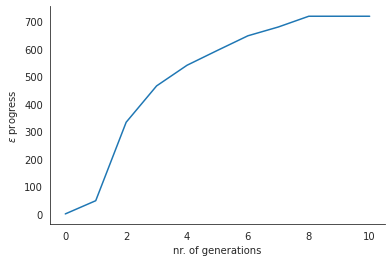

In [10]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

As can be seen from the output it only has one solution. This solution looks perfect for us, as we have no damages, deahts or costs see figure below. But this has to be questioned as it will most likely mean that others have to pay for everything. 

From the figure above we can see it has already started to converge, and with only one solution we don't really like to see that just yet. 

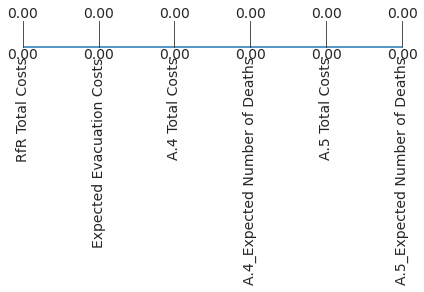

In [11]:
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

plt.show()

### Epsilon = 0.1

In [5]:
nfe = 10000
epsilon = [0.1,] * len(model.outcomes)
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 997/10000 nfe
[MainProcess/INFO] generation 15: 1497/10000 nfe
[MainProcess/INFO] generation 20: 1993/10000 nfe
[MainProcess/INFO] generation 25: 2493/10000 nfe
[MainProcess/INFO] generation 30: 2988/10000 nfe
[MainProcess/INFO] generation 35: 3487/10000 nfe
[MainProcess/INFO] generation 40: 3986/10000 nfe
[MainProcess/INFO] generation 45: 4486/10000 nfe
[MainProcess/INFO] generation 50: 4986/10000 nfe
[MainProcess/INFO] generation 55: 5486/10000 nfe
[MainProcess/INFO] generation 60: 5983/10000 nfe
[MainProcess/INFO] generation 65: 6483/10000 nfe
[MainProcess/INFO] generation 70: 6981/10000 nfe
[MainProcess/INFO] generation 75: 7479/10000 nfe
[MainProcess/INFO] generation 80: 7976/10000 nfe
[MainProcess/INFO] generation 85: 8471/10000 nfe
[MainProcess/INFO] generation 90: 8969/10000 nfe
[MainProcess/INFO] generation 95: 9469/10000 nfe
[MainProcess/INFO] generati

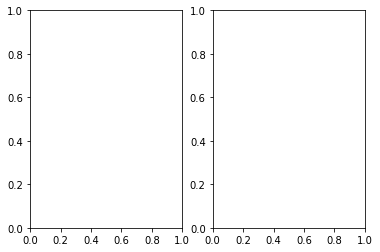

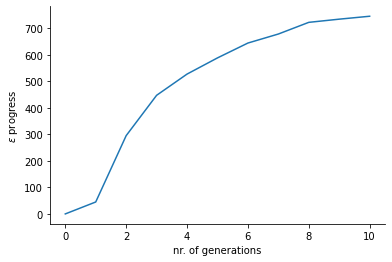

In [7]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

From the Figure and outcomes above we can see that using an epsilon value of 0.1 we get 23 outcomes and a figure that is close to being converged (stable in convergence)

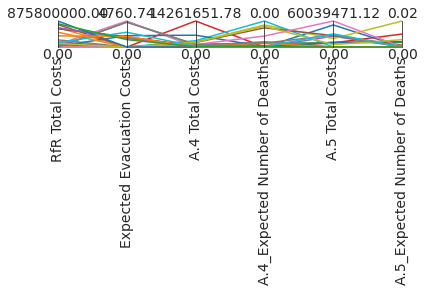

In [8]:
# print(results)
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

plt.show()

From the figure above, we can see that the costs can be pretty high, but deaths are almost always 0. So far we had not really encountered any problems so we would run these same uncertains with an epsilon of 0.05 minimizing deaths, costs and damages for all dike rings.

### 2. MORDM for all locations (Average Scenarios)

During our first run (we run the experiments for several times to get the outcomes above) of all the "epsilion-testing experiments", we only had 1 solution for an epsilon of 0.025, 2 solutions for 0.05 and 23 solutions for this (0.1). Eventually we wanted the results to be semi-strict, meaning we did not want to have too many, nor did we want to few.  \So we went with an epsilon value of 0.05 to be run extensively.

#### Specify problems and scenarios

The parameters in the reference scenario are set at their respetive average values

In [37]:
model, planning_steps = problem_definition('damage, cost, deaths')



reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate': 3.5,
                        'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name[:-2]]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]
nfe = 100000
epsilon = [0.05,] * len(model.outcomes)

#### Perform MOEA to find candidate solutions

In [19]:
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario)
results, convergence = total
save_results(total, './data/exp/MOEA100k.tar.gz')

[MainProcess/INFO] generation 0: 0/100000 nfe
[MainProcess/INFO] generation 5: 499/100000 nfe
[MainProcess/INFO] generation 10: 995/100000 nfe
[MainProcess/INFO] generation 15: 1493/100000 nfe
[MainProcess/INFO] generation 20: 1990/100000 nfe
[MainProcess/INFO] generation 25: 2487/100000 nfe
[MainProcess/INFO] generation 30: 2985/100000 nfe
[MainProcess/INFO] generation 35: 3480/100000 nfe
[MainProcess/INFO] generation 40: 3966/100000 nfe
[MainProcess/INFO] generation 45: 4461/100000 nfe
[MainProcess/INFO] generation 50: 4954/100000 nfe
[MainProcess/INFO] generation 55: 5445/100000 nfe
[MainProcess/INFO] generation 60: 5929/100000 nfe
[MainProcess/INFO] generation 65: 6388/100000 nfe
[MainProcess/INFO] generation 70: 6837/100000 nfe
[MainProcess/INFO] generation 75: 7292/100000 nfe
[MainProcess/INFO] generation 80: 7762/100000 nfe
[MainProcess/INFO] generation 85: 8226/100000 nfe
[MainProcess/INFO] generation 90: 8708/100000 nfe
[MainProcess/INFO] generation 95: 9181/100000 nfe
[MainPr

In [ ]:
save_results(total, './data/exp/MOEA100k.tar.gz')

In [30]:
total = load_results('./data/exp/MOEA100k.tar.gz')
archive, convergence = total

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\MOEA100k.tar.gz


#### Check convergency

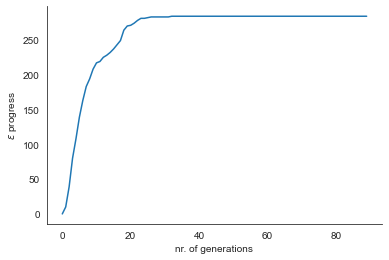

In [14]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence['epsilon_progress'])
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

From the output of the run we can see we now have 57 possible solutions to our problem, all defined on global outcome varialbes, that is focussed on all dike rings combined instead of only our own.

In [32]:
len(archive)

57

From the figure above we can clearly see that the model converges around 22000 number of generations, and is quite stable after that. This shows nfe = 100,000 is sufficient to make the model converge.

#### Visualize results

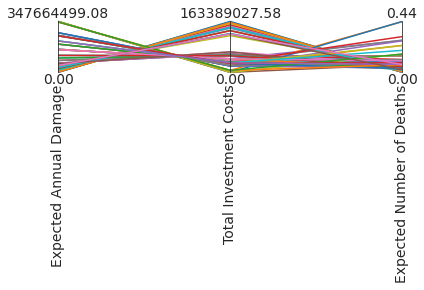

In [24]:
# print(results)
outcomes = results.loc[:, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

plt.show()

The figure shows us all 57 solutions combined, the values are hard to read, but this will be cleared up later on. 
The overview of this figure tells that low deaths and damages really do require a significant amount of investment. 

#### Re-evaluate the candidate solutions

we wanted to see what the MORDM optimization with average uncertainty and an epsilon of 0.05 brought us. So we use the candidate solutions to perform experiments again

In [38]:
policies = archive.drop([o.name for o in model.outcomes], axis=1).reset_index(drop=True)

pols_request_1 = []
for i, policy in policies.iterrows():
    pols_request_1.append(Policy(str(i), **policy.to_dict()))

In [ ]:
# Save experiment results
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios = 100,               #500
                                            policies=pols_request_1, reporting_interval=100)
save_results(results, './data/exp/solTest1.tar.gz')

##### process the results

In [4]:
results = load_results('./data/exp/solTest1.tar.gz')

experiments, outcomes = results
data = pd.DataFrame.from_dict(outcomes)

dam_list = ['Damage', 'Deaths','Investment','RfR','Evacuation']
data_agg = agg(data, dam_list)

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\solTest1.tar.gz


##### Visualize the results

[MainProcess/INFO] no time dimension found in results


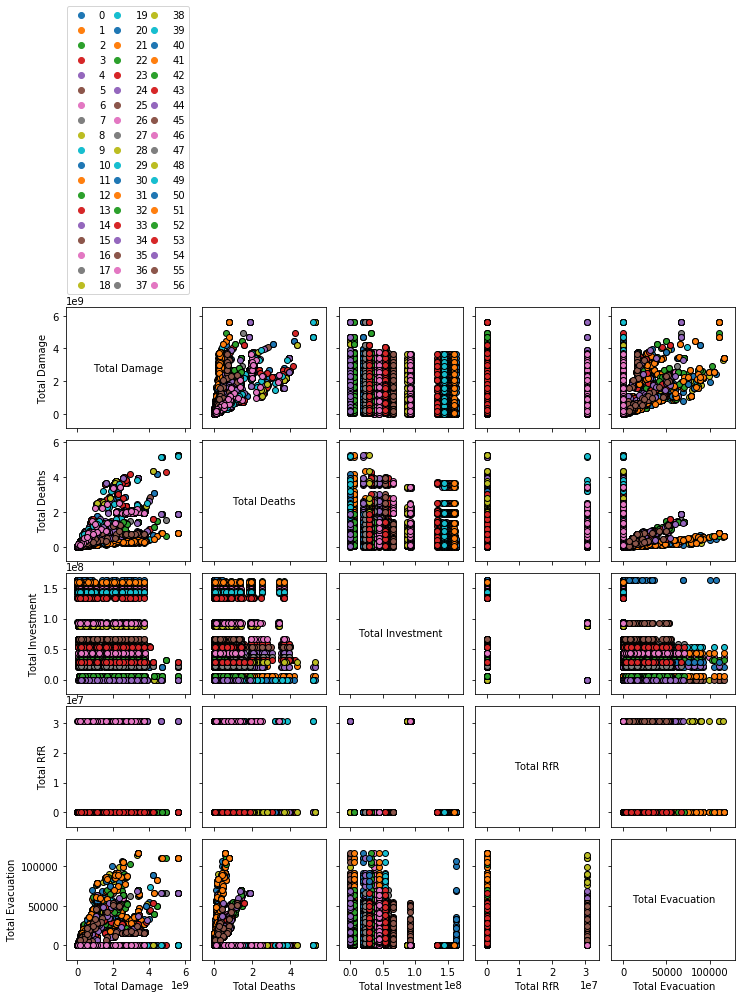

In [5]:
from ema_workbench.analysis import pairs_plotting

new_outcomes = {col:np.array(data_agg[col].tolist()) for col in data_agg.columns}

fig, ax = pairs_plotting.pairs_scatter(experiments, new_outcomes, group_by='policy', legend=True)
fig.set_size_inches([12, 12])
plt.savefig("./Figures/ScatterPlottingAvgExp.png")

The figure above shows the outcomes of 57 solutions under average uncertainty scenarios.

#### Calulate the average values of the outcomes per policy

In [84]:
n_scenarios = 100
policies = np.empty([len(experiments), 1])
k = 0
l = n_scenarios
for i in range (len(experiments)) : 
    policies[i] = k
    if (i == l - 1) : 
        k = k + 1
        l = l + n_scenarios
policies = policies.astype(int)

data1 = data_agg.copy()
data1['policy'] = policies

In [85]:
avg1 = data1.groupby(['policy']).mean()
avg1.to_csv("averge of outcomes_normaluncertainty.csv")

Looking at the average value of outcomes per policy, the deaths and damages generally are still high. But some policies have already effectively reduced the
damage and deaths campared to the base case.

#### Robustness insight (Maximum Regret)

In [18]:
results = load_results('./data/exp/solTest1.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\solTest1.tar.gz


In [19]:
new_outcomes = {col:np.array(data_agg[col].tolist()) for col in data_agg.columns}

In [20]:
def calculate_regret(data, best) : 
    return np.abs(best-data)

In [21]:
experiments, outcomes = results

regret = {}
max_regret = {}
for outcome in data_agg.columns:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome: new_outcomes[outcome], 
                         "policy":experiments['policy'],
                         "scenario_id":experiments['scenario']})
    
    data = data.pivot(index='scenario_id', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    regret[outcome] = regret
    max_regret[outcome] = outcome_regret.max()

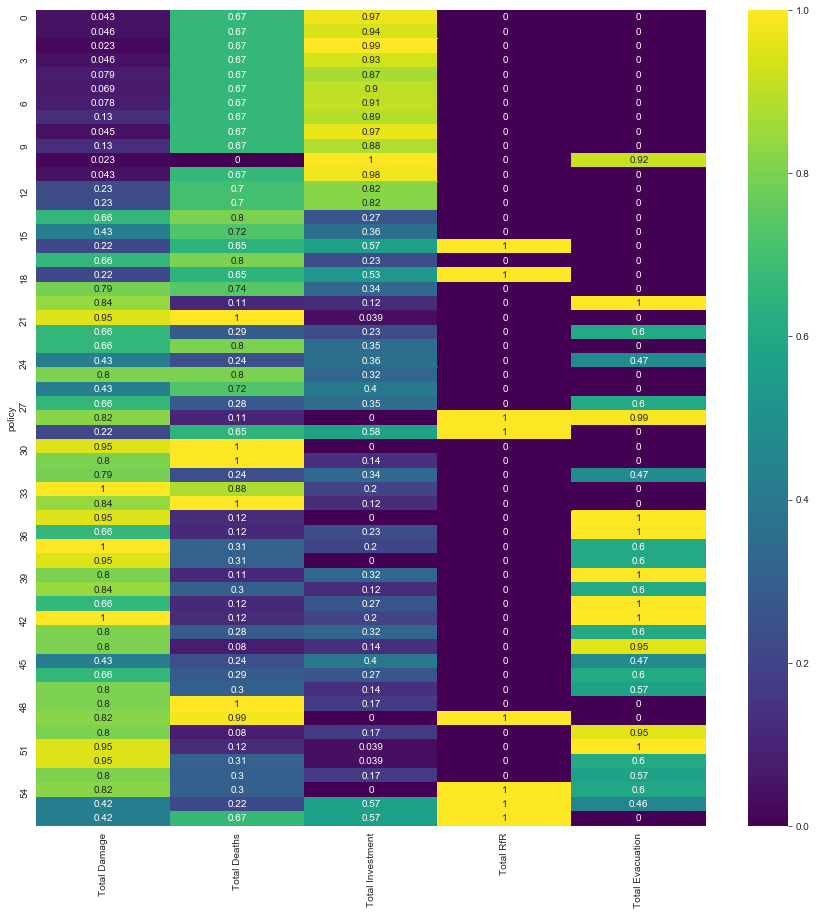

In [23]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
fig = plt.gcf()
fig.set_size_inches(15, 15)
# plt.savefig("mr_1")
plt.show()

### 3. Optimization for all location (worst-scenarios)

As explained we were not happy with the solutions the average uncertainties brought us. But a robust solution means the policies need to perform not so badly under the worst scenario, so we made a worst case scenario, in which each uncertainty is as bad as it can get, except for pfail, as setting that to the highest would mean a dike will always breach which is a bit too much in our opinion. 

We did this one according to the study guide, which said a lower pfail means a higher chance of a dike breaking, or in the words of the study guide: the higher the number the stronger the dike. We thought this was weird, but as it was in the study guide we stupidly trusted it. 

In the worst case, pfail is set as 0.9. The reason we chose 0.9 instead of 1 is simple, 1 would mean the dike will always break, whereas 0.9 it still has moments that it does not break. 

#### Specify the problems and scenarios

In [106]:
model, planning_steps = problem_definition('damage, cost, deaths')

In [68]:
reference_values = {'Bmax': 350, 'Brate': 10, 'pfail': 0.9,
                        'discount rate': 1.5,
                        'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name[:-2]]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]
epsilon = [0.05,] * len(model.outcomes)
nfe=50000

#### Perform MOEA over the worst scenario

In [15]:
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )
save_results(total, './data/exp/worstcaseoptv2.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 499/50000 nfe
[MainProcess/INFO] generation 10: 998/50000 nfe
[MainProcess/INFO] generation 15: 1494/50000 nfe
[MainProcess/INFO] generation 20: 1990/50000 nfe
[MainProcess/INFO] generation 25: 2488/50000 nfe
[MainProcess/INFO] generation 30: 2987/50000 nfe
[MainProcess/INFO] generation 35: 3482/50000 nfe
[MainProcess/INFO] generation 40: 3977/50000 nfe
[MainProcess/INFO] generation 45: 4473/50000 nfe
[MainProcess/INFO] generation 50: 4957/50000 nfe
[MainProcess/INFO] generation 55: 5418/50000 nfe
[MainProcess/INFO] generation 60: 5894/50000 nfe
[MainProcess/INFO] generation 65: 6348/50000 nfe
[MainProcess/INFO] generation 70: 6829/50000 nfe
[MainProcess/INFO] generation 75: 7291/50000 nfe
[MainProcess/INFO] generation 80: 7753/50000 nfe
[MainProcess/INFO] generation 85: 8233/50000 nfe
[MainProcess/INFO] generation 90: 8691/50000 nfe
[MainProcess/INFO] generation 95: 9161/50000

In [69]:
moea_total = load_results('./data/exp/worstcaseoptv2.tar.gz')
moea_1k_results, moea_1k_convergence = moea_total

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\worstcaseoptv2.tar.gz


##### Check convergency

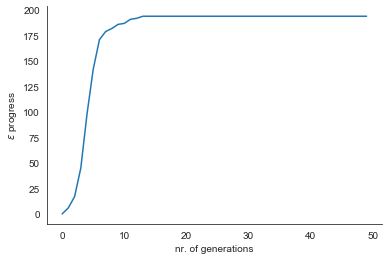

In [70]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(moea_1k_convergence['epsilon_progress'])
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

In [71]:
len(moea_1k_results)

19

19 solutions are found

#### Visualize the optimization tradeoffs

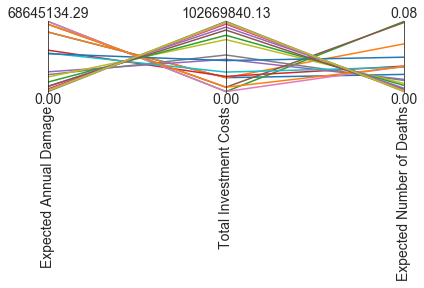

In [88]:
outcomes = moea_1k_results.loc[:, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

plt.show()

There is a significant tradeoff between the investment costs and the flood-caused damage/deaths

#### Re-evaluate the candidate solutions

In [72]:
policies = moea_1k_results.drop([o.name for o in model.outcomes], axis=1).reset_index(drop=True)

pols_evaluate = []
for i, policy in policies.iterrows():
    pols_evaluate.append(Policy(str(i), **policy.to_dict()))

In [11]:
dike_model, planning_steps = problem_definition('all vars')
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios = 100,               #500
                                            policies=pols_evaluate, reporting_interval=100)
save_results(results, './data/exp/solTestworstcase100.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 19 policies * 1 model(s) = 1900 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1100 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1300 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1700 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 1900 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to /h

##### Process results

In [114]:
results = load_results('./data/exp/solTestworstcase100.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\solTestworstcase100.tar.gz


In [26]:
experiments, outcomes = results
data_worst = pd.DataFrame.from_dict(outcomes)

dam_list = ['Damage', 'Deaths','Investment','RfR','Evacuation']
data_worst = agg(data_worst, dam_list)

##### Visualize the results

[MainProcess/INFO] no time dimension found in results


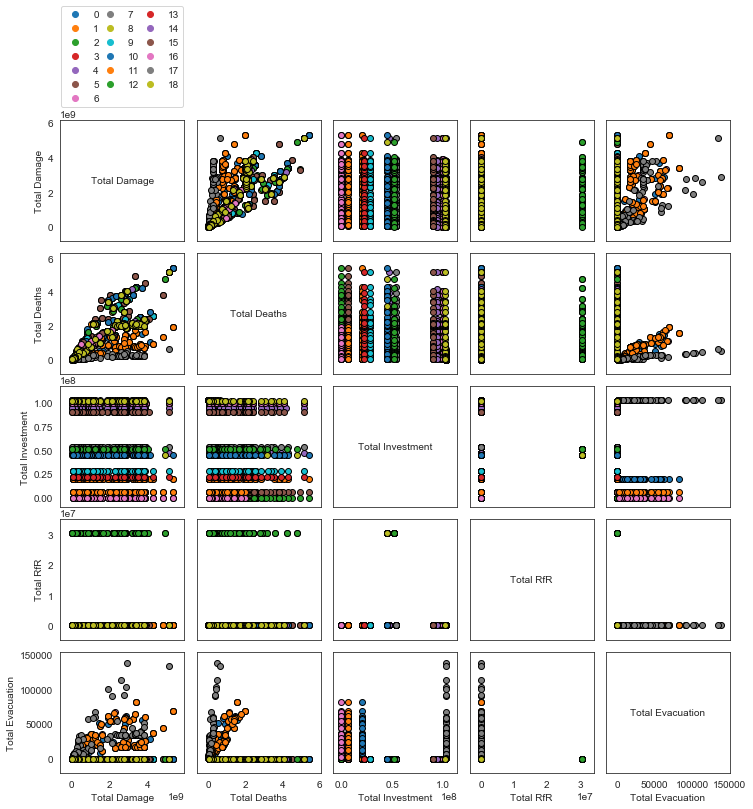

In [75]:
new_outcomes = {col:np.array(data_worst[col].tolist()) for col in data_worst.columns}

fig, ax = pairs_plotting.pairs_scatter(experiments, new_outcomes, group_by='policy', legend=True)
fig.set_size_inches([12, 12])
plt.savefig("./Figures/ScatterPlottingworstExp.png")
plt.show()

##### Calculate the average values of the outcomes per policy

In [77]:
n_scenarios = 100
policies = np.empty([len(experiments), 1])
k = 0
l = n_scenarios
for i in range (len(experiments)) : 
    policies[i] = k
    if (i == l - 1) : 
        k = k + 1
        l = l + n_scenarios
policies = policies.astype(int)

data2 = data_worst.copy()
data2['policy'] = policies

In [80]:
avg2 = data2.groupby(['policy']).mean()
avg2.to_csv("averge of outcomes_worstscenrio.csv")

In [81]:
avg2

,Total Damage,Total Deaths,Total Investment,Total RfR,Total Evacuation
policy,,,,,
0,1.701361e+09,0.524287,2.029929e+07,0.0,20984.706444
1,1.701361e+09,1.456354,2.029929e+07,0.0,0.000000
2,1.816190e+09,1.694514,0.000000e+00,0.0,0.000000
3,1.630832e+09,1.324787,2.216782e+07,0.0,0.000000
4,1.595752e+09,1.292734,4.720503e+07,0.0,0.000000
5,1.816660e+09,1.698027,6.320800e+06,0.0,0.000000
6,1.816190e+09,0.610025,0.000000e+00,0.0,24014.823975
7,1.595392e+09,1.296201,5.352583e+07,0.0,0.000000
8,1.549063e+09,1.230401,4.533650e+07,30700000.0,0.000000


#### Robustness insights

In [24]:
results = load_results('./data/exp/solTestworstcase100.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\teres\Documents\EPA1361-Model-based Decison Making\EPA1361\final assignment\data\exp\solTestworstcase100.tar.gz


In [27]:
new_outcomes = {col:np.array(data_worst[col].tolist()) for col in data_worst.columns}

##### Maximum Regret

In [28]:
def calculate_regret(data, best) : 
    return np.abs(best-data)

In [29]:
experiments, outcomes = results

regret = {}
max_regret = {}
for outcome in data_worst.columns:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome: new_outcomes[outcome], 
                         "policy":experiments['policy'],
                         "scenario_id":experiments['scenario']})
    
    data = data.pivot(index='scenario_id', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    regret[outcome] = regret
    max_regret[outcome] = outcome_regret.max()

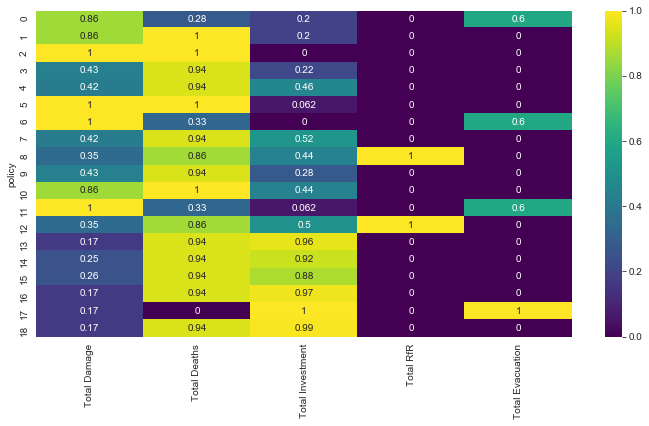

In [31]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.savefig("mr_2")
plt.show()

Policy 17 has the best performance in terms of total deaths, but this policy requires large investment and total evacuations

### 4 . (Suspended) MORO

At first we really wanted to do MORO instead of MORDM, however we failed to work it out due to time limitation. 

We used the basic arguments that were given to us in on of the example files. We might have changed a few things, but not much. In the end we changed the #scenarios and #nfe, which showed us it did work, however it is just really slow. MORO is really expensive computationally, so it takes a long time to complete. As this was so slow with similair settings to the ones used in MORDM, we switched our attention to MORDM. Later when we had some time left we wanted to check what problems we were having with MORO, so we significanlty lowered the #nfe and #scenarios and were able to get what is shown below. This took already pretty long to run, so we were unable to do an solid run of MORO. Although this run is so small, and might be considered bad as it did find 1 solution. 

In [13]:
model, planning_steps = problem_definition('damage, cost, deaths')

In [25]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.000001) 
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 100000)
Total_Investment_Costs = functools.partial(robustness, SMALLER, 150000000)

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MINIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage)]

n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)

In [26]:
nfe = 1000
BaseEvaluator.reporting_frequency = 0.1
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)
archive, convergence = total

[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 498/1000 nfe
[MainProcess/INFO] generation 10: 997/1000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions


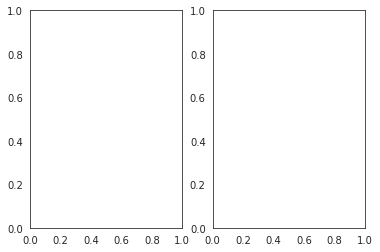

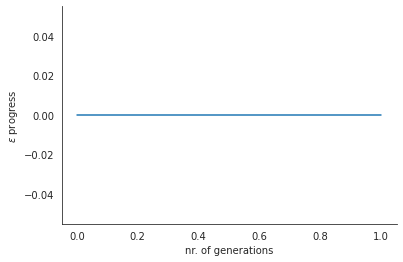

In [29]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

In [33]:
try:
    moro_total
except NameError:
    moro_total = None

# Test whether variable is defined to be None
if moro_total is None:
    moro_total = load_results('./data/exp/moro1k.tar.gz')
    moro_1k_results, moro_1k_convergence = moro_total

[MainProcess/INFO] results loaded succesfully from /home/jovyan/work/final assignment/data/exp/moro1k.tar.gz


   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        0        1        1        0        1        1   

   2_RfR 2  3_RfR 0  3_RfR 1  3_RfR 2  4_RfR 0  4_RfR 1  4_RfR 2  \
0        0        0        0        0        0        1        0   

   EWS_DaysToThreat  A.1_DikeIncrease 0  A.1_DikeIncrease 1  \
0                 0                  10                   8   

   A.1_DikeIncrease 2  A.2_DikeIncrease 0  A.2_DikeIncrease 1  \
0                   1                   2                   4   

   A.2_DikeIncrease 2  A.3_DikeIncrease 0  A.3_DikeIncrease 1  \
0                   1                   3                   5   

   A.3_DikeIncrease 2  A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
0                   1                  10                   1   

   A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                   4                   1                   9   

   A.5_DikeIncrease 2  fraction EA deaths  fraction EA da

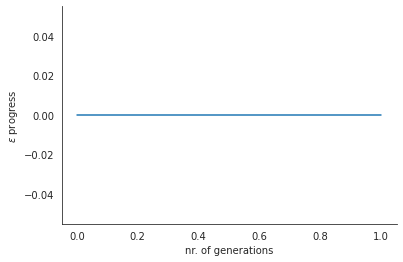

In [39]:
print(moro_1k_results)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(moro_1k_convergence['epsilon_progress'])
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

In [32]:
pd.set_option("display.max_columns", None)
print(archive)

   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        1        1        1        0        0        0   

   2_RfR 2  3_RfR 0  3_RfR 1  3_RfR 2  4_RfR 0  4_RfR 1  4_RfR 2  \
0        1        0        0        0        1        1        1   

   EWS_DaysToThreat  A.1_DikeIncrease 0  A.1_DikeIncrease 1  \
0                 0                   2                   0   

   A.1_DikeIncrease 2  A.2_DikeIncrease 0  A.2_DikeIncrease 1  \
0                   7                   8                   5   

   A.2_DikeIncrease 2  A.3_DikeIncrease 0  A.3_DikeIncrease 1  \
0                   8                   7                   2   

   A.3_DikeIncrease 2  A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
0                   9                   7                   7   

   A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                  10                   0                   7   

   A.5_DikeIncrease 2  fraction EA deaths  fraction EA da